In [1]:
import torch
from scripts import dog_breed
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
%matplotlib inline

In [2]:
dataset = ImageFolder('stanford_dogs/images/Images/')

In [3]:
test_pct = 0.3
test_size = int(len(dataset)*test_pct)
dataset_size = len(dataset) - test_size

val_pct = 0.1
val_size = int(dataset_size*val_pct)
train_size = dataset_size - val_size


train_size, val_size, test_size

(12966, 1440, 6174)

In [4]:
breeds = []

def rename(name):
    return name

for n in dataset.classes:
    breeds.append(rename(n))

In [5]:
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

(12966, 1440, 6174)

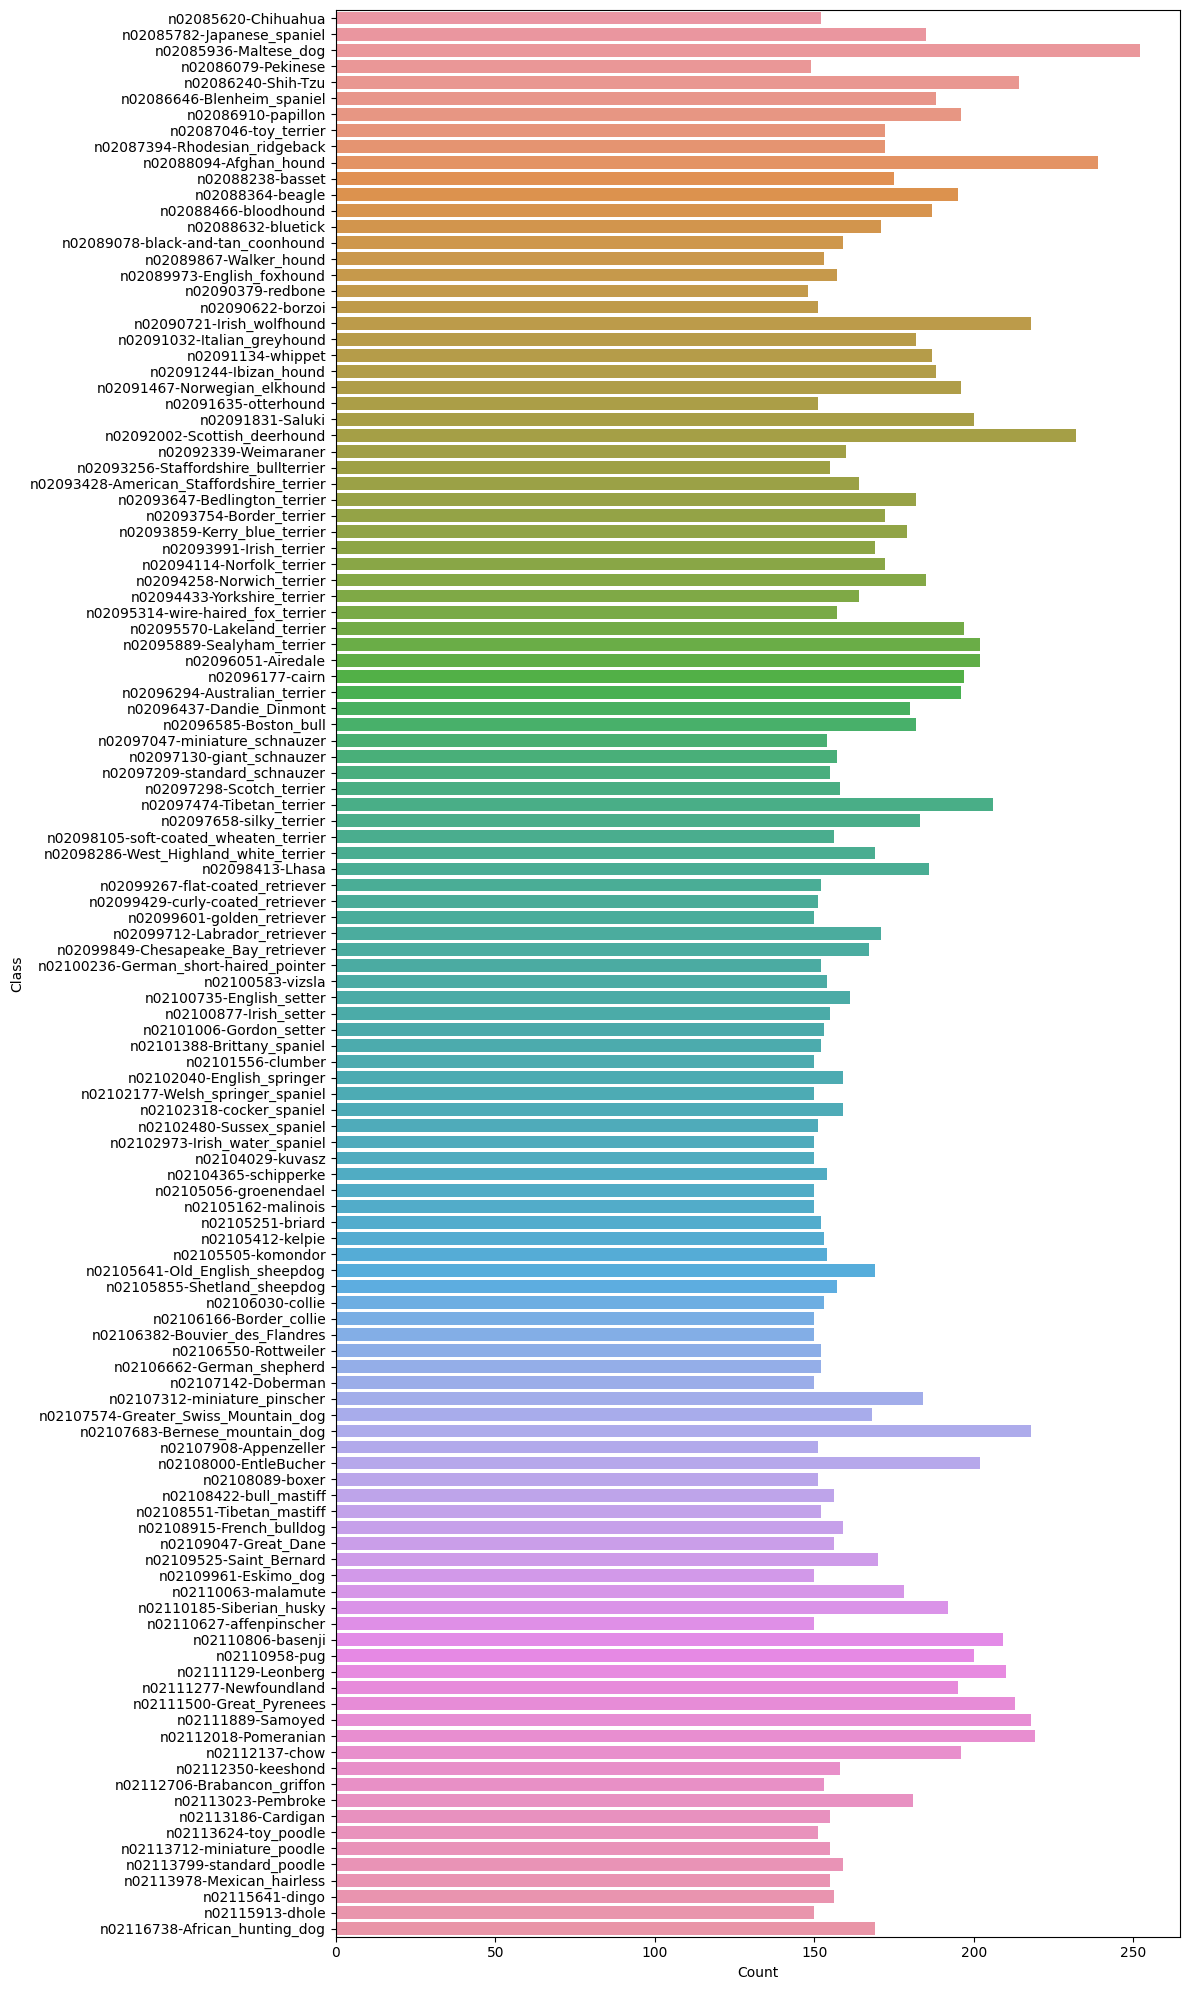

In [14]:
import pandas as pd
import seaborn as sns
class_names = dataset.classes
class_count = [dataset.targets.count(i) for i in range(len(class_names))]
df = pd.DataFrame({"Class": class_names, "Count": class_count})

plt.figure(figsize=(12, 20), dpi=100)
sns.barplot(x="Count", y="Class", data=df)
plt.tight_layout()
plt.show()

In [6]:

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
])

In [7]:
train_dataset = dog_breed.DogBreedDataset(train_ds, train_transform)
val_dataset = dog_breed.DogBreedDataset(val_ds, val_transform)
test_dataset = dog_breed.DogBreedDataset(test_ds, test_transform)

batch_size = 16

train_dl = DataLoader(train_dataset, batch_size, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size*2)
test_dl = DataLoader(test_dataset, batch_size*2)

36


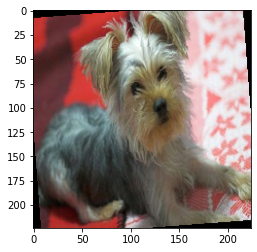

In [8]:
img, label = train_dataset[6]
print(label)
plt.imshow(img.permute(1,2,0))

In [20]:
import torchvision.models as models
model = models.vit_l_16 (pretrained = True)
input_size = model.heads.head.in_features

output_size = len(breeds)

model.heads.head = torch.nn.Linear(input_size, output_size)

for param in model.named_parameters () :
    if "heads" not in param[0]:
        param[1].requires_grad = False
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.99), eps=1e-08, weight_decay=1e-5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 5
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    dog_breed.train_one_epoch(model, train_dl, criterion, optimizer, device)
    dog_breed.test_model(model, test_dl, criterion, device)

Epoch 1/5


  1%|          | 5/811 [00:02<06:05,  2.21it/s]


KeyboardInterrupt: 

In [17]:
import torchvision.models as models
model = models.resnet34(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
    
num_classes = len(breeds)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001, betas=(0.9, 0.99), eps=1e-08, weight_decay=1e-5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 5
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    dog_breed.train_one_epoch(model, train_dl, criterion, optimizer, device)
    dog_breed.test_model(model, test_dl, criterion, device)


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5


100%|██████████| 811/811 [00:57<00:00, 14.01it/s]


Train Loss: 2.2503 Acc: 0.4735
Test Loss: 1.0914 Acc: 0.7013
Epoch 2/5


100%|██████████| 811/811 [00:58<00:00, 13.80it/s]


Train Loss: 1.2110 Acc: 0.6604
Test Loss: 0.9304 Acc: 0.7297
Epoch 3/5


100%|██████████| 811/811 [00:56<00:00, 14.33it/s]


Train Loss: 1.0732 Acc: 0.6859
Test Loss: 0.9544 Acc: 0.7238
Epoch 4/5


 14%|█▍        | 112/811 [00:07<00:48, 14.29it/s]


KeyboardInterrupt: 